# Week of 2025.04.28 

**Goals for the week:**
- [ ] Atmosphere integration 
    - [x] It appears from my [work the previous week](https://paxtonsc.github.io/files/geophysics/volcano_project/2025.04.14.experiments.html) that so long as we run the atmosphere simulation with a solution order of `0` the number of timesteps does not need to be increased. Experiment this week to see if that order is sufficient. **zeroth order appears insufficient.**
    - [x] Increase the mesh size so that we can compare the high station (2000m horizontal to the conduit) to the simulated data. 
    - [x] Update the mesh conduit radius to match the 5m in the eruption simulation.
    - [ ] Generate synthetic infrasound data at the station locations and compare to recorded infrasound data. Mario ball park  expects 800 Pa.
    - [ ] Try to increase the order of the infrasound animation. This may require messing with the mesh. 
    - [ ] Compare numerical results to rough analytical calculation based on this [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JB021940). 
- [x] Debugging the low density eruption simulation
    - [x] Why is the density/speed of sound so low? Mario was setting the mass fraction of water as the porosity (incorrect).
    - [x] Look into how to have the volume fraction of gas taken in as an initial condition? I decided it makes more sense to set the parameters correctly such that the gas volume fraction is what we want rather than directly setting the gas volume fraction. 
- [ ] Simple model for simulating parameters 
    - [ ] Review jump conditions + self similar rarefaction 
    - [ ] How can we create a simple model of the volcano eruption that accurately reflects the fragmentation front? 
- [ ] Get Mario's code for mapping pressure -> seismic behavior 

**Questions that arise:**
- [ ] How should I go about updating the mesh to make the simulation run at a higher order faster. Maybe a Fred question?

## 1.0 Generate synthetic infrasound data at the measuring stations

**Notes from Mario on how to handle the real infrasound data:**
- Band pass the infrasound data from 1 -> 20 Hz (use obspy)
- Mario has the factor of conversation (Mario to email it to Paxton) Mario will forward email with conversation factors. 
- We expect to see order 800 Pa
- Probably need the simulation to be 15 seconds. 

### 1.1 Review the updated eruption model

First, let's review the volcano eruption. Mario suggested some changes to the configuration file to reduce the low density in the plug we were seeing.

In [ ]:
ITERS=80

In [ ]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

solver_func = get_local_solver_from_index_func("eruption_model", "tungurahua_rad_5_v23_conduit")
ani = animate_conduit_pressure(solver_func, iterations=ITERS, viscosity_index=1, wall_friction_index=5, max_velocity=30, max_slip=60, max_tau=0.1, max_pressure=50, max_speed_of_sound=2000, max_water=20, max_density=5e3, max_fragmentation=5000, max_crystal=10)

HTML(ani.to_html5_video())

### 1.2 Animate pressure over time

How exactly does the atmosphere axisymmetric simulation work? Fred makes some notes in his [thesis](https://drive.google.com/drive/folders/1xwnqopoice-zy-8HfxhxLIeNJFAgZX5L). 

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (0.9e5, 1.01325e5)

# Initialize with first frame (index 0)
x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")
p0 = p.copy()  # Store initial pressure for reference
mdtools.plot_mean(x, p, clims)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x, p = mdtools.downsample(solver2D_from(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x, p, clims)
    plt.title(f"Pressure Field at Sec {round(0.1 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, ITERS, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

### 1.3 Relative pressure

We subtract out the initial pressure in order to only look at relative pressure, which is the quantity we are interested in. The simulation below does not make a lot of sense to me. I think by increasing the mesh size I may have borked something. 

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e2, 5e2)

# Initialize with first frame (index 0)
x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")
p0 = p.copy()  # Store initial pressure for reference
mdtools.plot_mean(x, p, clims)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=0, vmax=1e3),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x, p = mdtools.downsample(solver2D_from(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x, p-p0, clims)
    plt.title(f"Pressure Field at Sec {round(0.1 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, ITERS, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

Wow! That is pretty noisy. It is a little tricky to tell what is proper falloff versus numerical errors. 

In [15]:
# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (0, 1e3)

# Initialize with first frame (index 0)
x, p = mdtools.downsample(solver2D_from(0), plot_qty="Pressure")
p0 = p.copy()  # Store initial pressure for reference
mdtools.plot_mean(x, p, clims)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=0, vmax=1e3),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x, p = mdtools.downsample(solver2D_from(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x, p-p0, clims)
    plt.title(f"Pressure Field at Sec {round(0.1 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, 100, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

#### Next, let's plot the relative pressure at the high station. 

Where is the high station? According to [this paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL076419) it is 2000m horizontally from the outlet! I had to go back an expand the size of the mesh, but now we have data for the necessary domain. 

Next, let's create a plot of pressure versus time at a point roughly where the high station is. 

In [28]:
import matplotlib.tri as tri

# Assume solver2D_from is available as in the original code
solver2D_from = get_local_solver_from_index_func("eruption_model", "test_infrasound_v22_atm1")


triangulation = tri.Triangulation(solver2D_from(0).mesh.node_coords[...,0],
                  solver2D_from(0).mesh.node_coords[...,1], 
                  triangles=solver2D_from(0).mesh.elem_to_node_IDs)
                  
trifinder = triangulation.get_trifinder()

def find_elem_ID(x, y):
  ''' Returns element ID corresponding to given x and y. '''
  return trifinder(x, y)

def get_p_series(x_target, y_target):

  # Find the element ID
  elem_ID = find_elem_ID(x_target, y_target)

  print(f"Element ID for point ({x_target}, {y_target}): {elem_ID}")

  p_relative_arr = []
  p0 = None

  for i in range(0, ITERS):
      # Get the solver state at the current time step
      solver2D = solver2D_from(i)

      solver2D_0 = solver2D_from(0)

      U = solver2D.state_coeffs
      U_target = U[elem_ID:elem_ID+1]

      # Compute pressure using the state vector
      p_target = solver2D_0.physics.compute_variable("Pressure", U_target)

      if i == 0:
          p0 = p_target.item()

      p_relative_arr.append(p_target.item() - p0)
  
  return p_relative_arr
  

In [29]:
p_relative_arr_100 = get_p_series(100, 0)
p_relative_arr_200 = get_p_series(200, 0)
p_relative_arr_300 = get_p_series(300, 0)
p_relative_arr_400 = get_p_series(400, 0)
p_relative_arr_500 = get_p_series(500, 0)


Element ID for point (100, 0): 5999
Element ID for point (200, 0): 1089
Element ID for point (300, 0): 2091
Element ID for point (400, 0): 927
Element ID for point (500, 0): 626


Text(0.5, 0.98, 'Pressure Time Series at Different Distances from the outlet')

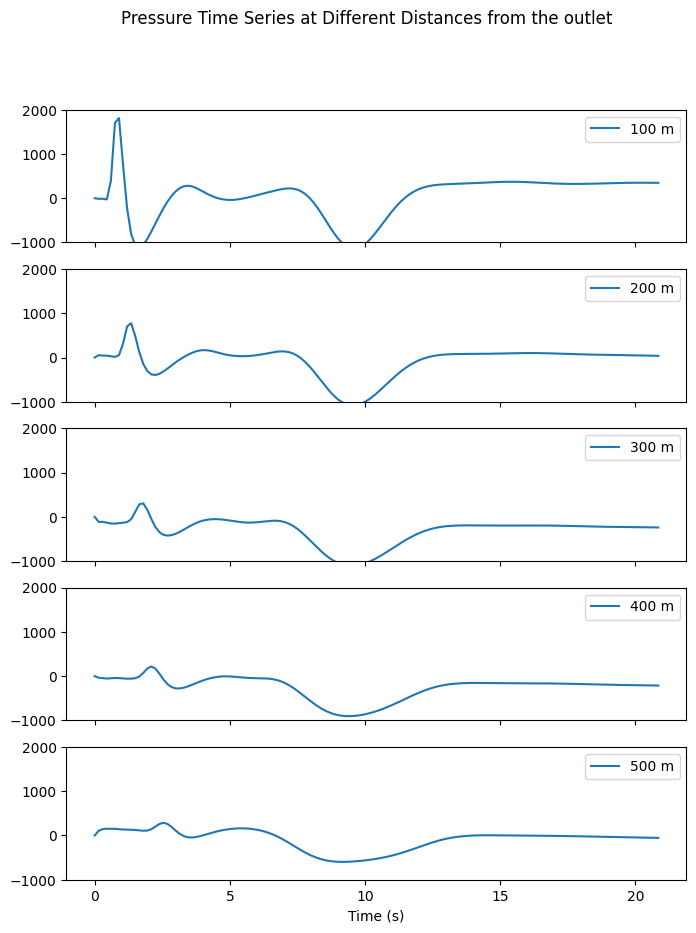

In [53]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_100, label="100 m")
axes[1].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_200, label="200 m")
axes[2].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_300, label="300 m")
axes[3].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_400, label="400 m")
axes[4].plot(np.arange(0, ITERS*(15/100), 15/100), p_relative_arr_500, label="500 m")

for ax in axes:
    ax.legend()
    ax.set_ylim(-1e3, 2e3)
    
plt.xlabel("Time (s)")
fig.suptitle("Pressure Time Series at Different Distances from the outlet")



It is odd that in the above chart the pressure drops about 400 Pascals. I am guessing that is just a function of diffusive numerical error. 

### 1.4 Plot observed infrasound data as a space time plot

The infrasound data can be found [here](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL076419). Well actually, I was unable to find a good way to download it from that link, but Mario shared this [google folder](https://drive.google.com/file/d/1uE-DbUshRbbkA-Hd7m-4wGWKaa8iPmGi/view?usp=drive_link) with me.

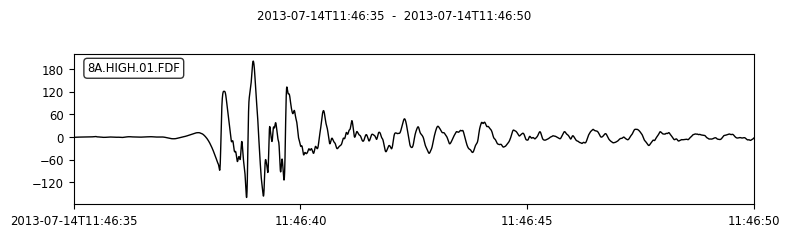

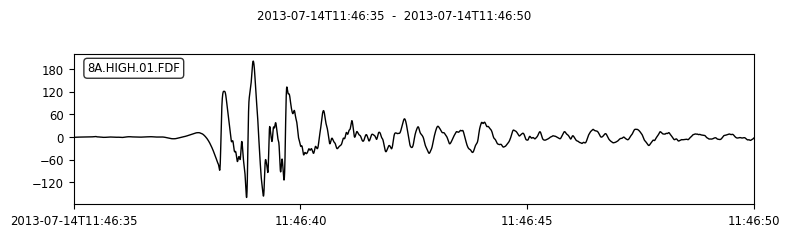

In [39]:
import matplotlib.pyplot as plt
import numpy as np

import obspy
from obspy import read, Stream, UTCDateTime
from obspy.io.mseed.util import get_record_information

file_path = "/Users/paxton/git/volcano_sims/infrasound_data/8A.HIGH.2013-07-14.mseed"

st = read(file_path)

tr0 = st[0]
tr0_filtered = tr0.copy()

freqmin = 1
freqmax = 20
tr0_filtered.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)

tr0_filtered.data = tr0_filtered.data * 1.589e-6 /  23e-6

t1 = UTCDateTime("2013-07-14T11:46:35")
t2 = UTCDateTime("2013-07-14T11:46:50")

tr0_filtered.trim(t1, t2)

tr0_filtered.plot()